In [13]:
import random
import math
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

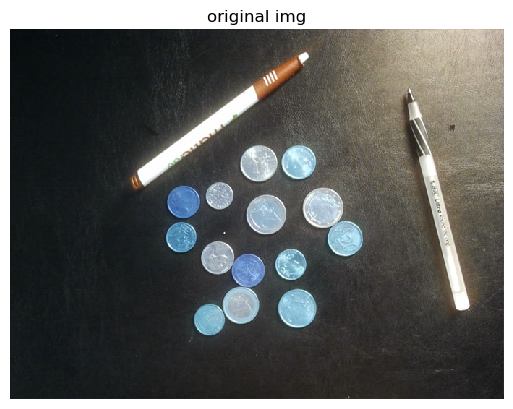

In [29]:
img = cv.imread('money2.jpg')
# img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.imshow(img)
plt.title('original img')
plt.axis('off')  # Turn off axis
plt.show()



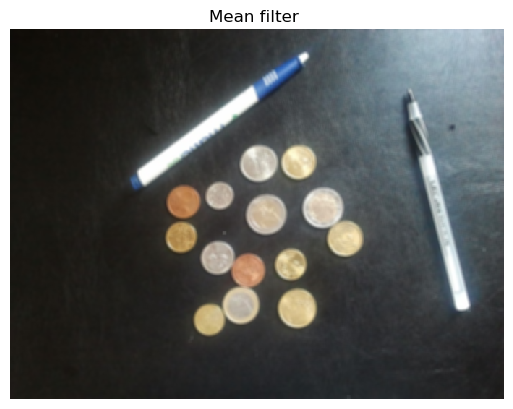

In [30]:
#create the kernel mean
kernelMean =  np.ones((5,5),np.float32)/ 25 # 

# apply it to the image now 
imgMean = cv.filter2D(img_rgb,-1,kernelMean)# 

#show it after 
plt.imshow(imgMean)
plt.title('Mean filter ')
plt.axis('off')  # Turn off axis
plt.show()

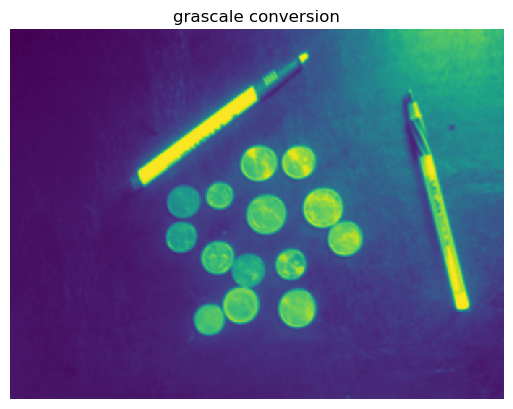

In [31]:
img_gray = cv.cvtColor(imgMean, cv.COLOR_RGB2GRAY)
plt.imshow(img_gray)
plt.title('grascale conversion')
plt.axis('off')  # Turn off axis
plt.show()

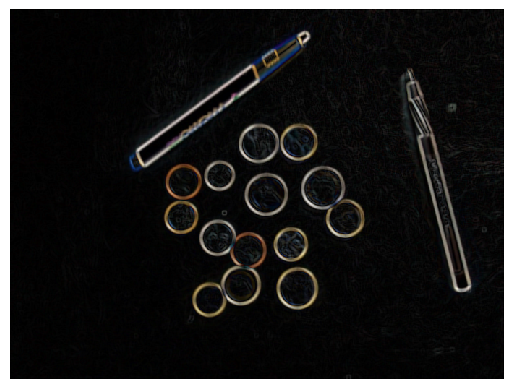

In [41]:
# computes the intensity gradient of the image using a Sobel kernel and plot it on mathplot to see intensity
# imgMean to be able to use the sobel filter 

sobel_x = cv.Sobel(imgMean, cv.CV_64F, 1, 0, ksize=3)
sobel_y = cv.Sobel(imgMean, cv.CV_64F, 0, 1, ksize=3)

gX = cv.convertScaleAbs(sobel_x )
gY = cv.convertScaleAbs(sobel_y)
# combine the gradient representations into a single image
combined = cv.addWeighted(gX, 0.5, gY, 0.5, 0)

plt.imshow(combined)
plt.title('Sobel')
plt.axis('off')  # Turn off axis
plt.show()


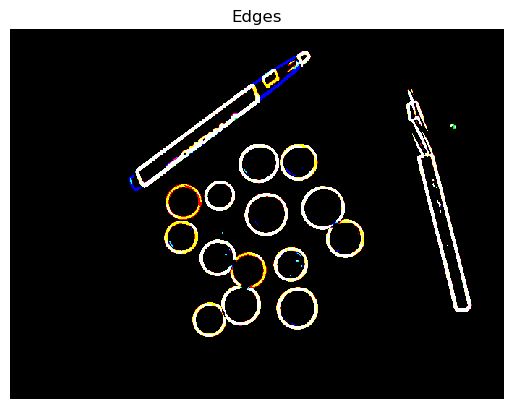

In [86]:
#remove all pixels that are not an edge using a local maximum and Hysteresis thresholding (i.e.the use of two threshold values to take a decision)
#change it an try doing opening and closing or as using here the gradient magnitude
# Compute the magnitude of the gradient
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
orientation = np.arctan2(gY, gX) * (180 / np.pi) % 180


threshold = 100
edges = np.uint8(gradient_magnitude > threshold) * 255


# Show the edges
plt.imshow(edges)
plt.title('Edges')
plt.axis('off')
plt.show()

In [98]:

#using the ransac here 
# Initialize variables
bestCircles = []
edgePoints = edges # Your edge points list
iterations = 100  # Your desired number of iterations

for _ in range(iterations):
    # Select three points at random among edgePoints vector
    A = edgePoints[random.randint(0, len(edgePoints)-1)]
    B = edgePoints[random.randint(0, len(edgePoints)-1)]
    C = edgePoints[random.randint(0, len(edgePoints)-1)]

    # Calculate midpoints
    midpt_AB = ((A[0] + B[0]) * 0.5, (A[1] + B[1]) * 0.5)
    midpt_BC = ((B[0] + C[0]) * 0.5, (B[1] + C[1]) * 0.5)

    # Calculate slopes and intercepts
    slope_AB = (B[1] - A[1]) / (B[0] - A[0] + 1e-15)  # Avoid division by zero
    intercept_AB = A[1] - slope_AB * A[0]
    slope_BC = (C[1] - B[1]) / (C[0] - B[0] + 1e-15)  # Avoid division by zero
    intercept_BC = C[1] - slope_BC * C[0]

    # Calculate perpendicular slopes and intercepts
    # Calculate perpendicular slopes and intercepts
    slope_midptAB = -1.0 / (slope_AB + 1e-15)  # Avoid division by zero
    slope_midptBC = -1.0 / (slope_BC + 1e-15)  # Avoid division by zero
    intercept_midptAB = midpt_AB[1] - slope_midptAB * midpt_AB[0]
    intercept_midptBC = midpt_BC[1] - slope_midptBC * midpt_BC[0]

    # Calculate intersection of perpendiculars to find center of circle and radius
    centerX = (intercept_midptBC - intercept_midptAB) / (slope_midptAB - slope_midptBC)
    centerY = slope_midptAB * centerX + intercept_midptAB
    center = (centerX, centerY)
    diffRadius_x = centerX - A[0]
    diffRadius_y = centerY - A[1]
    
    radius = np.mean(np.sqrt(diffRadius_x**2 + diffRadius_y**2))# neel formula

    circumference = 2.0 * math.pi * radius
    radiusThreshold = 3

    onCircle = []
    notOnCircle = []

# Iterate over edgePoints
    edgePoints = np.array(edgePoints) # create array of edge points

# Calculate the differences in x and y coordinates between edge points and center
    diffCenter_x = edgePoints[:, 0] - center[0]
    diffCenter_y = edgePoints[:, 1] - center[1]
    distanceToCenter = np.sqrt(diffCenter_x**2 + diffCenter_y**2)

# Calculate the distance from each edge point to the center
    
    # Check if the distance to the center is close to the radius
    close_to_radius = abs(distanceToCenter - radius) < radiusThreshold

# Append indices of points on and off the circle based on the condition
    onCircle.extend(np.where(close_to_radius)[0])
    notOnCircle.extend(np.where(~close_to_radius)[0])

# If number of edgePoints more than circumference, we found a correct circle
    if len(onCircle) >= circumference:
        bestCircles.append((center, radius))

# Remove edgePoints if circle found (only keep non-voting edgePoints)
    toKeep = [edgePoints[i] for i in notOnCircle] # accumulator array

# Store the circle information
    circleFound = (center[0], center[1], radius)

    # Stop iterations when there is not enough edgePoints
    if len(edgePoints) < 100:
        break


# Use np.all() to check if all values in each pixel are non-zero
print("Total edge points:", len(edgePoints))
print("circles found:", len(circleFound))# print to check if we found circles 

Total edge points: 512
circles found: 3


/tmp/ipykernel_26090/2138493311.py:31: RuntimeWarning: invalid value encountered in divide
  centerX = (intercept_midptBC - intercept_midptAB) / (slope_midptAB - slope_midptBC)


In [100]:
def draw_circle(img, center, radius, color, thickness):
    """
    Draw a circle on an image.

    :param img: The input image.
    :param center: The center of the circle (x, y).
    :param radius: The radius of the circle.
    :param color: The color of the circle (RGB tuple).
    :param thickness: The thickness of the circle.
    :return: The image with the circle drawn.
    """
    # Create a meshgrid of coordinates
    x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
    # Calculate distance from each pixel to the center of the circle
    dist = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    # Draw the circle by setting pixels within radius distance to the specified color
    img[(dist <= radius) & (dist >= radius - thickness)] = color
    return img
print("Detected circles:", bestCircles)


def draw_circles(img, best_circles, limit):
    """
    Draw best circles on image and display using Matplotlib but not showing for some reason
    :param img: The input image.
    :param best_circles: The best circles found.
    :param limit: The maximum number of circles to draw.
    """
    
    result = img_gray   # Associate the grayscale img to this
    for i in range(min(limit, len(best_circles))):
        center = (int(best_circles[i][0]), int(best_circles[i][1]))
        radius = int(best_circles[i][2])
        print("Drawing circle:", i+1, "Center:", center, "Radius:", radius)
        result = draw_circle(result, center, radius, (0, 255, 255), 3)
    
    return result



# circles have been found but the plotting part is the issue 

limit = 10  # Example limit
result_image = draw_circles()

# Display the result using Matplotlib
plt.imshow(result_image)
plt.axis('off')
plt.show()


Detected circles: []


TypeError: draw_circles() missing 3 required positional arguments: 'img', 'best_circles', and 'limit'